In [81]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
idx = pd.IndexSlice
pd.options.display.max_columns = 100
import requests, json
import seaborn as sb

The monthly marijuana sales data is published by the [Colorado Department of Revenue](https://www.colorado.gov/pacific/revenue/colorado-marijuana-sales-reports)

Write a test to make sure we can download a spreadsheet from the web and read it into Excel.

In [3]:
_df = pd.read_excel('https://www.colorado.gov/pacific/sites/default/files/0114_MarijuanaSalesReport%20PUBLISH.xlsx')
_df.head(10)

,State of Colorado,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Marijuana Sales Summary,NaN,NaN,NaN,NaN
1,Sales from January 2014,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,Medical Marijuana Sales 1,NaN,NaN,Retail Marijuana Sales 2,NaN
4,County,January 2014 \nSales 3,NaN,County,January 2014 \nSales 3
5,Adams,683098,NaN,Adams,NR
6,Alamosa,NR,NaN,Clear Creek,459640
7,Arapahoe,1188232,NaN,Denver,8482593
8,Archuleta,NR,NaN,Garfield,NR
9,Boulder,3417873,NaN,Gilpin,197379


# Marijuana sales data
Crawl all the data and add it to `data_dict` keyed by the month and year (as a string).

In [ ]:
data_dict = {}
for year in range(14,18):
    for month in range(1,13):
        try:
            url = 'https://www.colorado.gov/pacific/sites/default/files/{0:02d}{1}_MarijuanaSalesReport%20PUBLISH.xlsx'.format(month,year)
            data_dict['20{0}-{1:02d}'.format(year,month)] = pd.read_excel(url)
        except requests.exceptions.HTTPError:
            break

Write a function to clean up the Excel and turn it into tidier, long data.

In [5]:
def clean_excel(_df):
    # Get date
    #month = _df.loc[1,'State of Colorado'][11:]
    
    # Extract relevant rows
    cleaned_df = _df.loc[5:34]

    # Extract relevant columns
    cleaned_df = cleaned_df[cleaned_df.columns[[0,1,3,4]]]

    # Extract medical and retail data
    medical_df = cleaned_df.copy()[cleaned_df.columns[[0,1]]]
    retail_df = cleaned_df.copy()[cleaned_df.columns[[2,3]]]

    # Rename columns
    medical_df.columns = ['County','Sales']
    retail_df.columns = ['County','Sales']

    medical_df['Type'] = 'Medical'
    retail_df['Type'] = 'Retail'
    
    # Append
    combined_df = medical_df.append(retail_df)
    
    # Date
    #combined_df['Month'] = month

    # Clean
    combined_df = combined_df.dropna(subset=['County']).reset_index(drop=True)
    combined_df = combined_df[~combined_df['County'].isin(['Sum of NR Counties 4','Total 5'])]
    combined_df.replace({'Sales':{'NR':np.nan}},inplace=True)
    
    return combined_df

Clean the data.

In [7]:
cleaned_dict = {}

# Apply the function to each month's spreadsheet
for _month, _df in data_dict.items():
    cleaned_dict[_month] = clean_excel(_df)

# Combine all the months of data together
combined_df = pd.concat(cleaned_dict.values(),keys=cleaned_dict.keys()).reset_index(0)

# Cleanup
combined_df = combined_df.rename(columns={'level_0':'Month'})
combined_df['Month'] = pd.to_datetime(combined_df['Month'])

# Write to disk
combined_df.to_csv('CO_monthly_sales_data.csv')

combined_df.head()

,Month,County,Sales,Type
0,2014-01-01,Adams,683098.0,Medical
1,2014-01-01,Alamosa,NaN,Medical
2,2014-01-01,Arapahoe,1188232.0,Medical
3,2014-01-01,Archuleta,NaN,Medical
4,2014-01-01,Boulder,3417873.0,Medical


# Update data

Update the data for each new month.

In [12]:
old_data = pd.read_csv('CO_monthly_sales_data.csv',index_col=0,parse_dates=['Month'])
old_data.head()

,Month,County,Sales,Type
0,2014-01-01,Adams,683098.0,Medical
1,2014-01-01,Alamosa,NaN,Medical
2,2014-01-01,Arapahoe,1188232.0,Medical
3,2014-01-01,Archuleta,NaN,Medical
4,2014-01-01,Boulder,3417873.0,Medical


In [14]:
# Get the data
new_url = 'https://www.colorado.gov/pacific/sites/default/files/1117_MarijuanaSalesReport%20PUBLISH.xlsx'
new_raw = pd.read_excel(new_url)

# Clean
new_df = clean_excel(new_raw)
new_df['Month'] = pd.Timestamp('2017-11-01')

# Combine
new_combined_df = old_data.append(new_df)

# Wrte
new_combined_df.to_csv('CO_monthly_sales_data.csv')

# Inspect
new_combined_df.tail()

,County,Month,Sales,Type
55,Park,2017-11-01,323525.0,Retail
56,Pitkin,2017-11-01,571977.0,Retail
57,Pueblo,2017-11-01,3320340.0,Retail
58,Routt,2017-11-01,661206.0,Retail
59,Saguache,2017-11-01,95793.0,Retail


# Analyze data

In [105]:
combined_df = pd.read_csv('CO_monthly_sales_data.csv',index_col=0,parse_dates=['Month'])
combined_df['Month of Year'] = combined_df['Month'].apply(lambda x:x.month)
combined_df.head()

,County,Month,Sales,Type,Month of Year
0,Adams,2014-01-01,683098.0,Medical,1
1,Alamosa,2014-01-01,NaN,Medical,1
2,Arapahoe,2014-01-01,1188232.0,Medical,1
3,Archuleta,2014-01-01,NaN,Medical,1
4,Boulder,2014-01-01,3417873.0,Medical,1


Make a "wide" DataFrame.

In [54]:
wide_df = combined_df.set_index(['Type','Month','County'])['Sales'].unstack(['County'])
wide_df.head()

County                 Adams  Alamosa   Arapahoe  Archuleta    Boulder  \
Type    Month                                                            
Medical 2014-01-01  683098.0      NaN  1188232.0        NaN  3417873.0   
        2014-02-01  454940.0      NaN  1210155.0        NaN  3345413.0   
        2014-03-01  477275.0      NaN  1490219.0        NaN  3505875.0   
        2014-04-01  452636.0      NaN  1517828.0        NaN  3136133.0   
        2014-05-01  467977.0      NaN  1511922.0        NaN  2823124.0   

County              Chaffee  Clear Creek  Costilla      Denver     Eagle  \
Type    Month                                                              
Medical 2014-01-01  83714.0     143736.0       NaN  15351083.0  203060.0   
        2014-02-01      NaN     111164.0       NaN  14680476.0  185360.0   
        2014-03-01      NaN     106955.0       NaN  16102218.0  201147.0   
        2014-04-01      NaN      92791.0       NaN  15064678.0  178397.0   
        2014-05-01  88974.0      97349.0       NaN  14150620.0  146126.0   

County                El Paso   Fremont  Garfield   Gilpin  Grand  Gunnison  \
Type    Month                                                                 
Medical 2014-01-01  4923633.0  134388.0  396086.0  28798.0    NaN   36244.0   
        2014-02-01  5116438.0  215839.0  373432.0  32325.0    NaN       NaN   
        2014-03-01  5929766.0  222270.0  401766.0  33416.0    NaN       NaN   
        2014-04-01  5535184.0  225243.0  371447.0  43162.0    NaN       NaN   
        2014-05-01  5518910.0  239918.0  434235.0  42979.0    NaN       NaN   

County              Jefferson  La Plata    Larimer  Mesa  Moffat  Montezuma  \
Type    Month                                                                 
Medical 2014-01-01  1979386.0  523193.0   964948.0   NaN     NaN   100634.0   
        2014-02-01  2044484.0  521985.0  1009841.0   NaN     NaN   103266.0   
        2014-03-01  2014285.0  587114.0  1234344.0   NaN     NaN        NaN   
        2014-04-01  2039086.0  613521.0  1162178.0   NaN     NaN   108703.0   
        2014-05-01  2037535.0  561810.0  1116171.0   NaN     NaN   120385.0   

County              Montrose  Ouray  Park    Pitkin    Pueblo     Routt  \
Type    Month                                                             
Medical 2014-01-01       NaN    NaN   NaN  194865.0  419894.0  239509.0   
        2014-02-01       NaN    NaN   NaN  161237.0  418489.0  209165.0   
        2014-03-01       NaN    NaN   NaN  157541.0  375711.0  214650.0   
        2014-04-01       NaN    NaN   NaN  123525.0  401959.0  186308.0   
        2014-05-01       NaN    NaN   NaN   95001.0  452196.0  159620.0   

County              San Miguel  Sedgwick  Lake  Summit  Weld  Saguache  \
Type    Month                                                            
Medical 2014-01-01    164384.0       NaN   NaN     NaN   NaN       NaN   
        2014-02-01     94099.0       NaN   NaN     NaN   NaN       NaN   
        2014-03-01     75215.0       NaN   NaN     NaN   NaN       NaN   
        2014-04-01     64107.0       NaN   NaN     NaN   NaN       NaN   
        2014-05-01     49679.0       NaN   NaN     NaN   NaN       NaN   

County              Morgan  Las Animas  San Juan  Huerfano  Conejos  Otero  
Type    Month                                                               
Medical 2014-01-01     NaN         NaN       NaN       NaN      NaN    NaN  
        2014-02-01     NaN         NaN       NaN       NaN      NaN    NaN  
        2014-03-01     NaN         NaN       NaN       NaN      NaN    NaN  
        2014-04-01     NaN         NaN       NaN       NaN      NaN    NaN  
        2014-05-01     NaN         NaN       NaN       NaN      NaN    NaN

Plot retail sales over time of the top 5 counties.

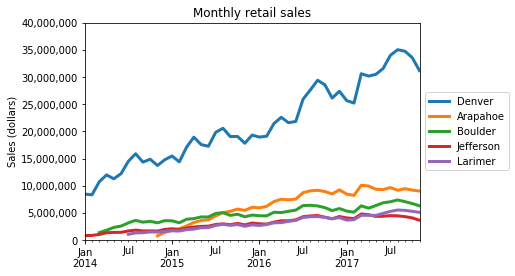

In [55]:
top_5_counties = wide_df.loc['Retail',:].sum().sort_values(ascending=False).index[:5]
top_5_df = wide_df.loc['Retail',top_5_counties]

ax = top_5_df.plot(legend=False,lw=3)
ax.set_title('Monthly retail sales')
ax.set_xlabel('')
ax.set_ylabel('Sales (dollars)')
ax.set_ylim((0,4e7))

# https://stackoverflow.com/a/46574866/1574687
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.legend(loc='center left',bbox_to_anchor=(1,.5))

# Monthly changes

Plot percentage changes in total sales over time.

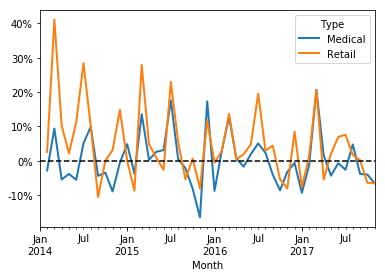

In [121]:
ax = combined_df.groupby(['Type','Month']).agg({'Sales':np.sum})['Sales'].unstack(0).pct_change().plot(lw=2)
ax.axhline(0,color='k',ls='--')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))

Group trends by month of the year to see historical patterns.

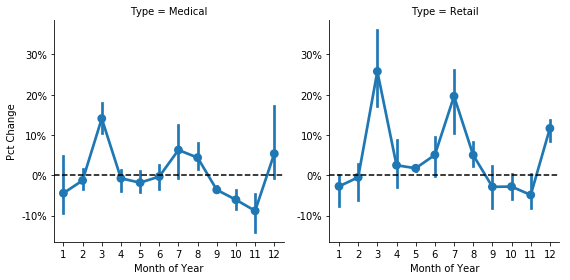

In [122]:
monthly_cycles_df = combined_df.groupby(['Type','Month']).agg({'Sales':np.sum})['Sales'].unstack(0).pct_change().reset_index()
monthly_cycles_df['Month of Year'] = monthly_cycles_df['Month'].apply(lambda x:x.month)

monthly_cycles_melted_df = pd.melt(monthly_cycles_df,id_vars=['Month of Year'],value_vars=['Medical','Retail'],value_name='Pct Change')
g = sb.factorplot(x='Month of Year',y='Pct Change',col='Type',data=monthly_cycles_melted_df)#,linestyles=['',''])
g.axes[0][0].axhline(0,color='k',ls='--')
g.axes[0][1].axhline(0,color='k',ls='--')
g.axes[0][0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
g.axes[0][1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))

### Month-to-month and year-to-year changes

Compute month-to-month and year-to-year changes.

In [107]:
# Changes since last month
mom_changes = wide_df.loc[idx[['Medical','Retail'],['2017-10-01','2017-11-01']],:]

# Changes since last year
yoy_changes = wide_df.loc[idx[['Medical','Retail'],['2016-11-01','2017-11-01']],:]

In [108]:
mom_changes_s = mom_changes.diff().loc[idx[['Medical','Retail'],['2017-11-01']],].T
mom_changes_s.columns = mom_changes_s.columns.droplevel(1)
mom_changes_s.dropna(how='all').sort_values('Retail')

Type,Medical,Retail
County,,
Denver,-1150291.0,-2390788.0
Jefferson,-167194.0,-425578.0
Boulder,-98809.0,-414098.0
Las Animas,888.0,-235531.0
La Plata,-21155.0,-217912.0
Pueblo,-37490.0,-205455.0
Garfield,-22065.0,-191959.0
Larimer,-28356.0,-190129.0
Arapahoe,-172580.0,-186910.0


In [110]:
mom_pct_changes_s = mom_changes.pct_change().loc[idx[['Medical','Retail'],['2017-11-01']],].T
mom_pct_changes_s.columns = mom_pct_changes_s.columns.droplevel(1)
mom_pct_changes_s = mom_pct_changes_s.dropna(how='all').sort_values('Retail')
mom_pct_changes_s.style.format({'Medical':'{:,.2%}'.format,'Retail':'{:,.2%}'.format})

Type,Medical,Retail
County,,
Costilla,nan%,-30.50%
Chaffee,nan%,-23.07%
Gunnison,nan%,-22.90%
Saguache,nan%,-18.74%
Pitkin,-6.05%,-18.72%
Lake,nan%,-15.43%
Routt,nan%,-14.34%
Archuleta,nan%,-11.56%
La Plata,-7.06%,-11.06%


In [116]:
mom_pct_changes_s.mean().apply(lambda x:'{:,.2%}'.format(x))

Type
Medical    -4.73%
Retail     -9.97%
dtype: object

In [60]:
yoy_changes_s = yoy_changes.diff().loc[idx[['Medical','Retail'],['2017-11-01']],].T
yoy_changes_s.columns = yoy_changes_s.columns.droplevel(1)
yoy_changes_s.dropna(how='all').sort_values('Retail')

Type,Medical,Retail
County,,
Jefferson,-171710.0,-256715.0
Gilpin,NaN,1694.0
Costilla,NaN,19540.0
Grand,NaN,21688.0
Clear Creek,-31691.0,22731.0
La Plata,-61216.0,34520.0
Chaffee,NaN,39775.0
Gunnison,NaN,42941.0
Park,NaN,45535.0


In [113]:
yoy_pct_changes_s = yoy_changes.pct_change().loc[idx[['Medical','Retail'],['2017-11-01']],].T
yoy_pct_changes_s.columns = yoy_pct_changes_s.columns.droplevel(1)
yoy_pct_changes_s = yoy_pct_changes_s.dropna(how='all').sort_values('Retail')
yoy_pct_changes_s.style.format({'Medical':'{:,.2%}'.format,'Retail':'{:,.2%}'.format})

Type,Medical,Retail
County,,
Jefferson,-11.65%,-6.52%
Gilpin,nan%,0.90%
La Plata,-18.03%,2.01%
Clear Creek,-45.23%,5.27%
Arapahoe,-48.24%,6.11%
Costilla,nan%,8.55%
Grand,nan%,8.66%
Eagle,-21.05%,10.58%
Gunnison,nan%,11.00%


In [115]:
yoy_pct_changes_s.mean().apply(lambda x:'{:,.2%}'.format(x))

Type
Medical    -11.78%
Retail      19.54%
dtype: object

# County populations
Normalize sales data by county size. Colorado's State Demography Office publishes [population forecasts for 2000-2050](https://demography.dola.colorado.gov/population/population-totals-counties/) for each county.

Get this spreadsheet.

In [10]:
forecasts_raw_df = pd.read_excel('https://drive.google.com/uc?export=download&id=0B-vz6H4k4SESdkNHSng2VGlEc1k')
forecasts_raw_df.head()

,"TABLE III - C - 1. PRELIMINARY POPULATION FORECASTS FOR COLORADO COUNTIES, 2000 - 2050.",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,SDO Est.,SDO Est.,SDO Est.,SDO Est.,SDO Est.,SDO Est.,SDO Est.,SDO Est.,SDO Est.,...,SDO Proj.,SDO Proj.,SDO Proj.,SDO Proj.,SDO Proj.,SDO Proj.,SDO Proj.,SDO Proj.,SDO Proj.,SDO Proj.
2,Counties,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,COLORADO,4338801,4444513,4504709,4555084,4608811,4662534,4745660,4821784,4901938,...,7.85119e+06,7.92434e+06,7.9959e+06,8.06596e+06,8.13485e+06,8.20171e+06,8.26767e+06,8.33283e+06,8.39733e+06,8.4613e+06


Clean it up.

In [11]:
# Rename columns
forecasts_raw_df.columns = forecasts_raw_df.loc[2]

# Subset to rows with data
cleaned_forecasts_df = forecasts_raw_df.loc[6:]

# Reshape data
cleaned_forecasts_df = cleaned_forecasts_df.set_index('Counties').T

# Clean out the trailing whitespace 
cleaned_forecasts_df.columns = [name.strip() for name in cleaned_forecasts_df.columns]
cleaned_forecasts_df.index = [year.strip() for year in cleaned_forecasts_df.index]
cleaned_forecasts_df.index.name = 'Year'

# Subset to relevant years
overlapping_years_df = cleaned_forecasts_df.loc[['2014','2015','2016','2017']]
overlapping_years_df

,Adams,Alamosa,Arapahoe,Archuleta,Baca,Bent,Boulder,Broomfield,Chaffee,Cheyenne,...,Routt,Saguache,San Juan,San Miguel,Sedgwick,Summit,Teller,Washington,Weld,Yuma
Year,,,,,,,,,,,,,,,,,,,,,
2014,479777,15845,617936,12258,3624,5747,313190,61554,18459,1847,...,24010,6171,719,7751,2331,29213,23402,4772,275845,10178
2015,489923,15968,629066,12417,3594,5847,318570,64656,18603,1830,...,24310,6219,696,7843,2389,29928,23431,4834,284571,10052
2016,497673,16131,637254,12907,3557,5626,321989,66252,19097,1853,...,24679,6404,698,8000,2421,30367,24154,4875,294397,10082
2017,509473,16308,646725,13152.3,3544.6,5660.77,325607,68552.2,19391.2,1853.86,...,25136,6457.9,703.725,8266.45,2411.66,30959.3,24649.9,4904.65,304803,10142.4


Visualize population trends just for kicks. I didn't realize that Colorado Springs ([El Paso County](https://www.google.com/maps/place/El+Paso+County,+CO/)) was posed to overtake Denver County in population by 2030. 

* [Arapahoe County](https://www.google.com/maps/place/Arapahoe+County,+CO/) includes Denver's southeastern surburbs
* [Adams County](https://www.google.com/maps/place/Adams+County,+CO/) includes Denver's northeastern suburbs
* [Weld County](https://www.google.com/maps/place/Weld+County,+CO/) includes the exurbs east of Boulder, Loveland, and Fort Collins
* [Jefferson County](https://www.google.com/maps/place/Jefferson+County,+CO/) includes Denver's western suburbs.
* [Larimer County](https://www.google.com/maps/place/Larimer+County,+CO/) includes Loveland and Fort Collins
* [Douglas County](https://www.google.com/maps/place/Douglas+County,+CO/) includes the exurbs to the south of Denver and the north of Colorado Springs
* [Boulder County](https://www.google.com/maps/place/Boulder+County,+CO/) includes Boulder and its surrounding "L" towns (Longmont, Lyons, Lafayette, Louisville)
* [Mesa County](https://www.google.com/maps/place/Mesa+County,+CO/) includes Grand Junction

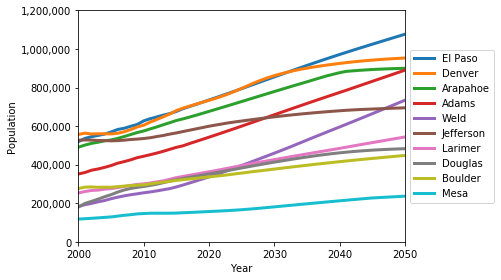

In [13]:
top_counties_by_pop = cleaned_forecasts_df.max().sort_values(ascending=False).index[:10]

top_pop_df = cleaned_forecasts_df.loc[:,top_counties_by_pop]
ax = top_pop_df.plot(lw=3,legend=False)
ax.set_ylim((0,1200000))

# https://stackoverflow.com/a/46574866/1574687
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax.set_ylabel('Population')
plt.legend(loc='center left',bbox_to_anchor=(1,.5))
plt.tight_layout()
plt.savefig('pop_forecasts.png',dpi=300,bbox_inches='tight')

Because I'm still curious, here are the counties with the highest and lowest changes in population 2000-2050.

In [14]:
# http://composition.al/blog/2015/11/29/a-better-way-to-add-labels-to-bar-charts-with-matplotlib/

def autolabel(ax,scale):
    rects = ax.patches
    # Get x-axis height to calculate label position from.
    (x_bottom, x_top) = ax.get_xlim()
    x_width = x_top - x_bottom

    for rect in rects:
        width = rect.get_width()
        label_position = width + (x_width * scale)

        ax.text(label_position, rect.get_y(), #+ rect.get_height()/2., 
                '{0:.2f}'.format(width), ha='center', va='bottom', fontsize=10)

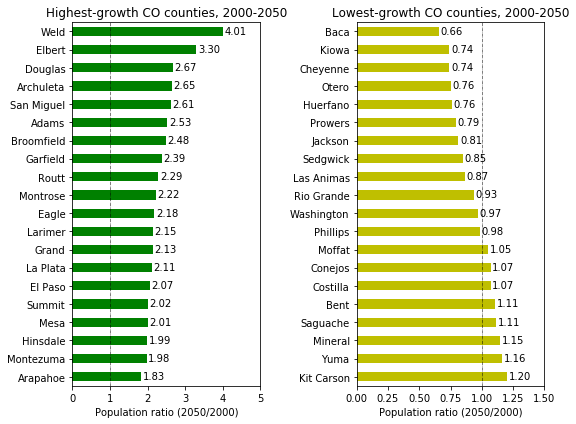

In [15]:
growth_s = cleaned_forecasts_df.loc['2050']/cleaned_forecasts_df.loc['2000']
growth_s = growth_s.sort_values(ascending=False)

f,axs = plt.subplots(1,2,figsize=(8,6))

# Fastest-growing
fast_s = growth_s.head(20).sort_values()
fast_s.plot(ax=axs[0],kind='barh',color='g')
#axs[0].invert_yaxis()
axs[0].set_xlim((0,5))
axs[0].set_xlabel('Population ratio (2050/2000)')
axs[0].set_title('Highest-growth CO counties, 2000-2050')
axs[0].axvline(1,color='k',ls='-.',lw=.5)

# Slowest-growing
slow_s = growth_s.tail(20)
slow_s.plot(ax=axs[1],kind='barh',color='y')
axs[1].set_xlim((0,1.5))
axs[1].set_xlabel('Population ratio (2050/2000)')
axs[1].set_title('Lowest-growth CO counties, 2000-2050')
axs[1].axvline(1,color='k',ls='-.',lw=.5)

# Label bars
autolabel(axs[0],.0675)
autolabel(axs[1],.0675)

plt.tight_layout()
plt.savefig('pop_change.png',dpi=300,bbox_inches='tight')

Back to data-munging. We need to reformat the `overlapping_years_df` and join it with the `combined_df` sales data so we can divide the latter by the former to get per-capita sales.

In [17]:
# http://composition.al/blog/2015/11/29/a-better-way-to-add-labels-to-bar-charts-with-matplotlib/

def autolabel2(ax,scale):
    """Differences in text formatting for currency"""
    rects = ax.patches
    # Get x-axis height to calculate label position from.
    (x_bottom, x_top) = ax.get_xlim()
    x_width = x_top - x_bottom

    for rect in rects:
        width = rect.get_width()
        label_position = width + (x_width * scale)

        ax.text(label_position, rect.get_y() + rect.get_height()/2., 
                '${0:,.0f}'.format(width), ha='center', va='center', fontsize=10)

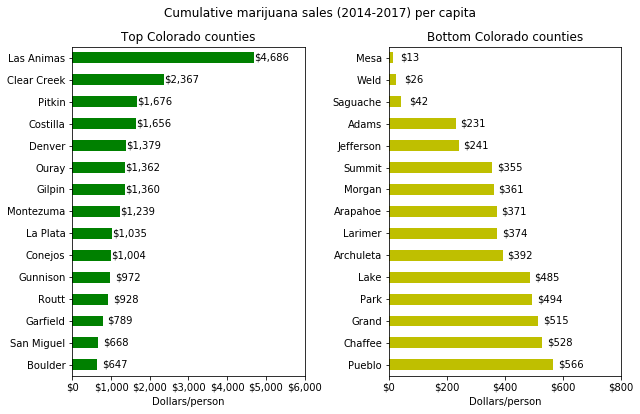

In [20]:
# Get the cumulative retail sales data by county
c_retail_sales = wide_df.fillna(0).loc['Retail',:].sum()
pop_2017 = overlapping_years_df.loc['2017']
sales_per_capita = (c_retail_sales/pop_2017)
sales_per_capita = sales_per_capita.replace({0:np.nan})
sales_per_capita = sales_per_capita.dropna().sort_values(ascending=False)

# Plot it
f,axs = plt.subplots(1,2,figsize=(9,6))

top_sales_per_capita = sales_per_capita.head(15).sort_values()
top_sales_per_capita.plot(kind='barh',ax=axs[0],color='g')
#axs[0].invert_yaxis()
axs[0].set_xlabel('Dollars/person')
axs[0].set_title('Top Colorado counties')
axs[0].set_xlim((0,6000))
# https://stackoverflow.com/a/46574866/1574687
axs[0].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))

bot_sales_per_capita = sales_per_capita.tail(15)
axs[1] = bot_sales_per_capita.plot(kind='barh',ax=axs[1],color='y')
axs[1].set_xlabel('Dollars/person')
axs[1].set_title('Bottom Colorado counties')
axs[1].set_xlim((0,800))
# https://stackoverflow.com/a/46574866/1574687
axs[1].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))

# Label bars
autolabel2(axs[0],.075)
autolabel2(axs[1],.075)

plt.suptitle('Cumulative marijuana sales (2014-2017) per capita')

plt.tight_layout(rect=[0,0.03,1,.95])
plt.savefig('cumulative_marijuana_sales_per_county.png',dpi=300,bbox_inches='tight')